In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
source_train_dir = '/kaggle/input/dataset1/train'
source_val_dir = '/kaggle/input/dataset1/val'

target_dir = '/kaggle/working/dataset'

os.makedirs(target_dir, exist_ok=True)

def copy_classes(source_dir, target_dir):
    for class_folder in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_folder)
        class_target_path = os.path.join(target_dir, class_folder)

        if os.path.isdir(class_source_path):
            shutil.copytree(class_source_path, class_target_path, dirs_exist_ok=True)

copy_classes(source_train_dir, target_dir)
copy_classes(source_val_dir, target_dir)

print("Class directories copied successfully!")

Class directories copied successfully!


In [3]:
base_dir = '/kaggle/working/dataset'
categories = ['insang', 'kawung', 'parang','sidoluhur', 'tumpal', 'mega_mendung']

In [4]:
def load_images(base_dir, categories, img_size=(224, 224)):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(base_dir, category)
        for filename in os.listdir(category_path):
            if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
                img_path = os.path.join(category_path, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(category)
    return np.array(images), np.array(labels)

images, labels = load_images(base_dir, categories)

In [5]:
def display_sample_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        idx = np.random.randint(len(images))
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis('off')
    plt.show()

In [6]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

In [7]:
images = images / 255.0


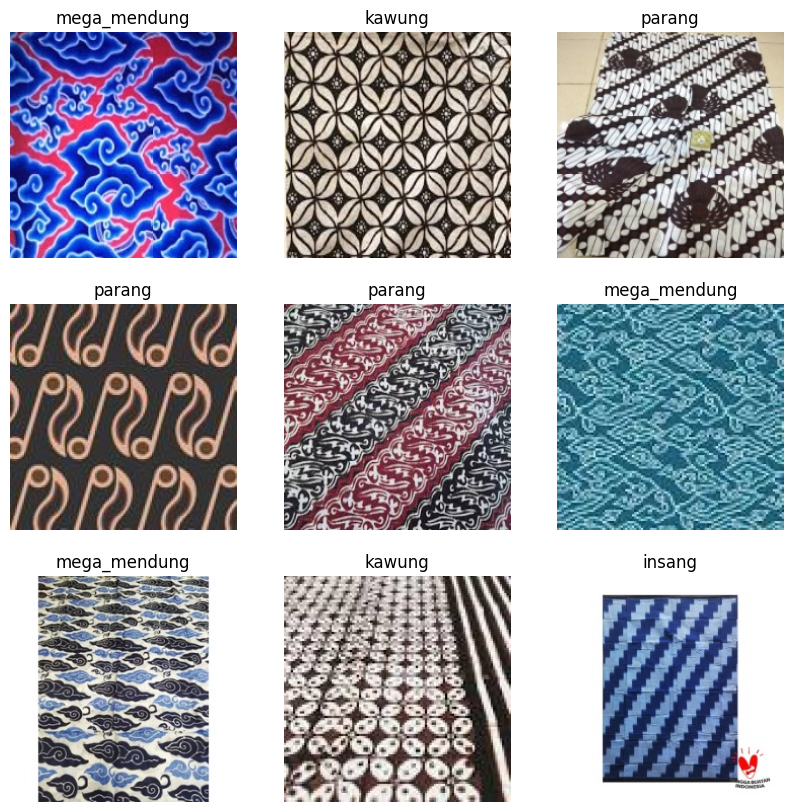

In [8]:
class_names = le.classes_
display_sample_images(images, labels_encoded.argmax(axis=1), class_names)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

In [10]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

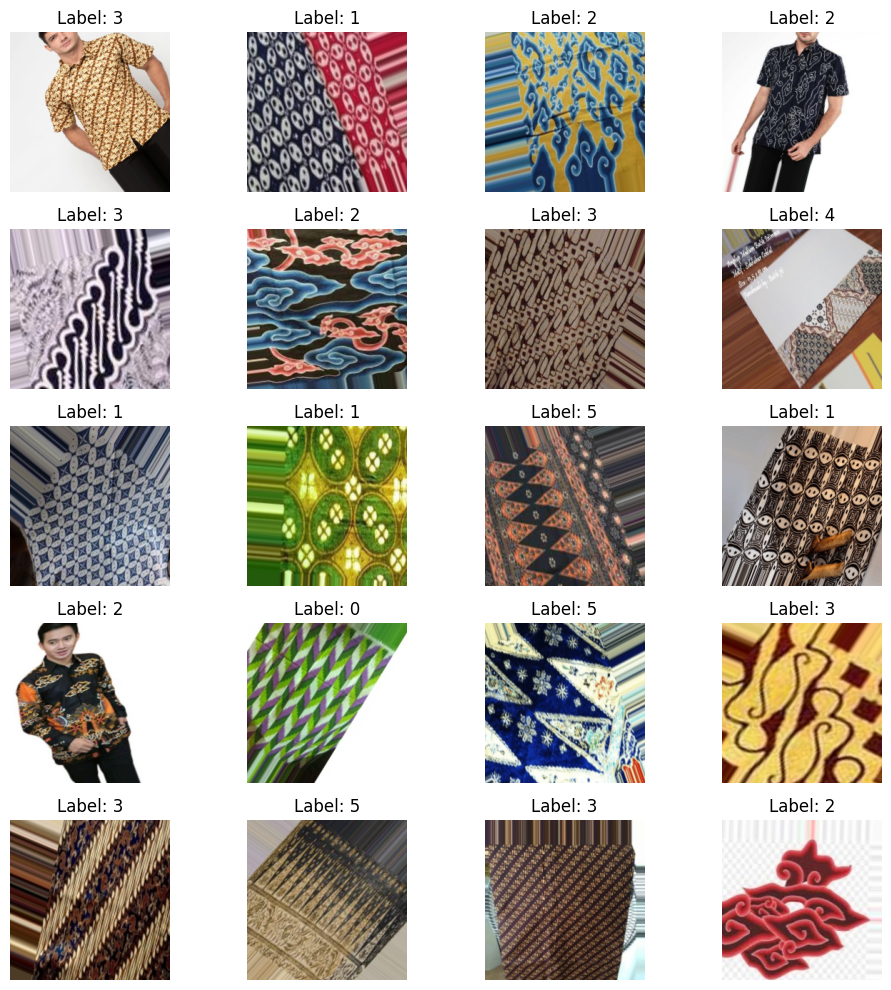

In [11]:
dir_It = datagen.flow(X_train, y_train, batch_size=1)

fig, axes = plt.subplots(5, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(20):
    img, label = next(dir_It)
    axes[i].imshow(img[0])
    axes[i].set_title(f"Label: {np.argmax(label)}")
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [12]:
print("Unique classes and counts:", dict(zip(*np.unique(labels, return_counts=True))))
print("Categories list:", categories)
print("Encoded class indices:", le.classes_)


Unique classes and counts: {'insang': 208, 'kawung': 413, 'mega_mendung': 421, 'parang': 399, 'sidoluhur': 142, 'tumpal': 127}
Categories list: ['insang', 'kawung', 'parang', 'sidoluhur', 'tumpal', 'mega_mendung']
Encoded class indices: ['insang' 'kawung' 'mega_mendung' 'parang' 'sidoluhur' 'tumpal']


In [13]:


# Load the VGG16 model without the top (fully connected) layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False

# Build the model
model = Sequential()

# Add VGG16 as the base model
model.add(vgg_base)
model.add(Flatten())

# Add custom layers on top of VGG16
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Final output layer with softmax activation
model.add(Dense(len(categories), activation='softmax'))

# Build the model with the given input shape
model.build(input_shape=(None, 224, 224, 3))

# Fine-tune the last 3 layers of the VGG16 model
for layer in vgg_base.layers[-3:]:
    layer.trainable = True

# Summarize the model architecture
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,321,030 (62.26 MB)

 Trainable params: 6,325,830 (24.13 MB)

 Non-trainable params: 9,995,200 (38.13 MB)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00000001)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=200,
                    callbacks=[reduce_lr])

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733391645.212992      72 service.cc:145] XLA service 0x7ec044003830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733391645.213063      72 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/43 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.2656 - loss: 2.0896  

I0000 00:00:1733391656.422887      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 622ms/step - accuracy: 0.2074 - loss: 2.1986 - val_accuracy: 0.1462 - val_loss: 1.8458 - learning_rate: 1.0000e-06
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - accuracy: 0.2057 - loss: 2.1633 - val_accuracy: 0.2047 - val_loss: 1.7692 - learning_rate: 1.0000e-06
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - accuracy: 0.2303 - loss: 2.0951 - val_accuracy: 0.2807 - val_loss: 1.6934 - learning_rate: 1.0000e-06
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.2644 - loss: 1.9803 - val_accuracy: 0.3421 - val_loss: 1.6306 - learning_rate: 1.0000e-06
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - accuracy: 0.2925 - loss: 1.8695 - val_accuracy: 0.3860 - val_loss: 1.5658 - learning_rate: 1.0000e-06
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.2948 - loss: 1.8226 - val_accuracy: 0.4240 - val_loss: 1.5058 - learning_rate: 1.0000e-06
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8922 - loss: 0.4496
Test Accuracy: 89.18%


In [16]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


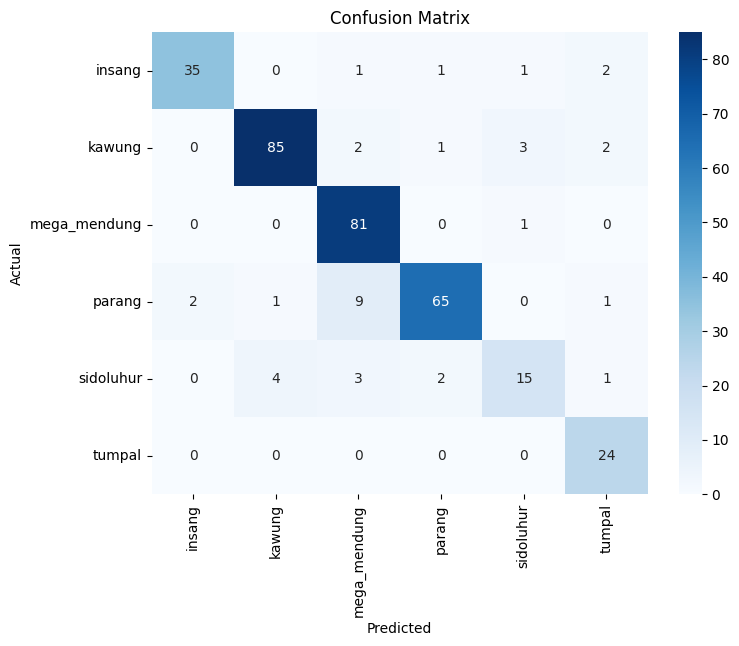

In [17]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      insang       0.95      0.88      0.91        40
      kawung       0.94      0.91      0.93        93
mega_mendung       0.84      0.99      0.91        82
      parang       0.94      0.83      0.88        78
   sidoluhur       0.75      0.60      0.67        25
      tumpal       0.80      1.00      0.89        24

    accuracy                           0.89       342
   macro avg       0.87      0.87      0.86       342
weighted avg       0.90      0.89      0.89       342



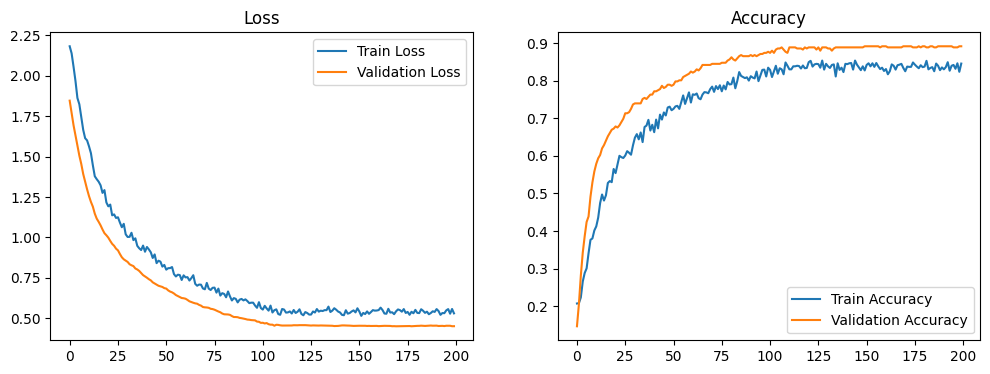

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [20]:
# Save the model
model.save(base_dir + 'model/model_batik_classifier.h5')
import joblib

# Save the model
joblib.dump(model, base_dir + 'model/model_batik_classifier.sav')

['/kaggle/working/datasetmodel/model_batik_classifier.sav']

In [21]:
from tensorflow.keras.models import load_model

# Lokasi folder testing
TEST_DIR = '/kaggle/input/dataset1/test'

# Memuat model terbaik
best_model = load_model(base_dir + 'model/model_batik_classifier.h5')

# Daftar semua file gambar di folder test
image_files = [file for file in os.listdir(TEST_DIR) if file.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]

if len(image_files) == 0:
    print("No test images found!")
else:
    for image_file in image_files:
        # Path lengkap untuk setiap gambar
        image_path = os.path.join(TEST_DIR, image_file)

        # Memuat dan memproses gambar
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Memprediksi kelas gambar
        prediction = best_model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        predicted_class = ["insang", "kawung", "mega_mendung", "parang", "sidoluhur", "tumpal"][predicted_class_index]  # Sesuaikan urutan label dengan model Anda

        # Menampilkan hasil prediksi
        print(f"Image: {image_file}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {np.max(prediction):.2%}")
        print("---")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: parang1.jpg
Predicted Class: mega_mendung
Confidence: 48.35%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: sidoluhur 2.png
Predicted Class: sidoluhur
Confidence: 38.87%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: parang.webp
Predicted Class: sidoluhur
Confidence: 42.40%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: insang.png
Predicted Class: insang
Confidence: 98.44%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: tumpal.jpeg
Predicted Class: sidoluhur
Confidence: 57.89%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: parang.jpg
Predicted Class: parang
Confidence: 91.70%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: megamendung.png
Predicted Class: mega_mendung
Confidence: 95.43%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: tumpal.jpg
Predicted Class: sidoluhur
Confidence: 57.89%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: sidoluhur3.png
Predicted Class: sidoluhur
Confidence: 52.24%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18m